In [1]:
# a foray into digital removal of lipofuscin through sparse decomposition.
# original code by brianl@alleninstitute.org

import sklearn.decomposition as skd
import numpy as np
import matplotlib.pyplot as plt
import time
import tifffile as tf
import os

import warnings
warnings.filterwarnings('ignore')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original shape: (2048, 2048, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


new shape: (500, 500, 4)


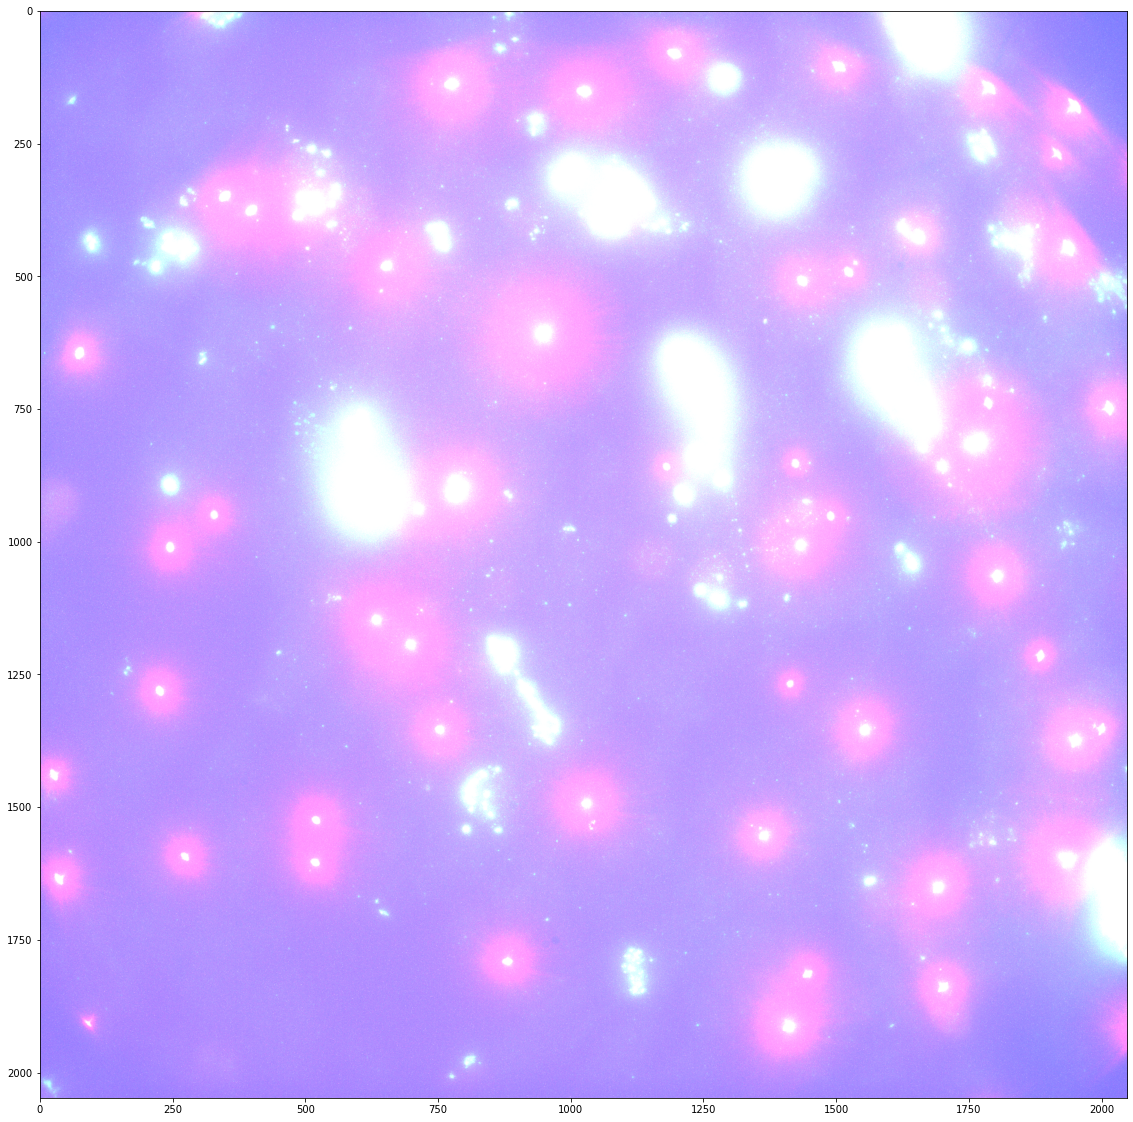

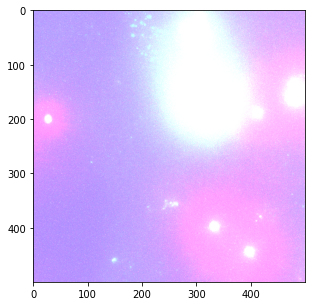

In [2]:
#import sample image
#this particular sample contains four channels:
#488, 568, 647, and DAPI/468

img_sample = tf.imread('C:/Users/John/Downloads/4-color_MIP_example.tif')

#reshaping axes so that channels are in third dimension
img_sample = np.transpose(img_sample,axes=[1,2,0])

#slicing a smaller subsample
img_sub = img_sample[750:1250,300:800,:].astype(np.float)

print("original shape: {}".format(img_sample.shape))
plt.figure(figsize=(20,20))
plt.imshow(img_sample.astype(np.int))

print("new shape: {}".format(img_sub.shape))
plt.figure(figsize=(5,5))
plt.imshow(img_sub.astype(np.int))

Text(0.5, 1.0, 'DAPI')

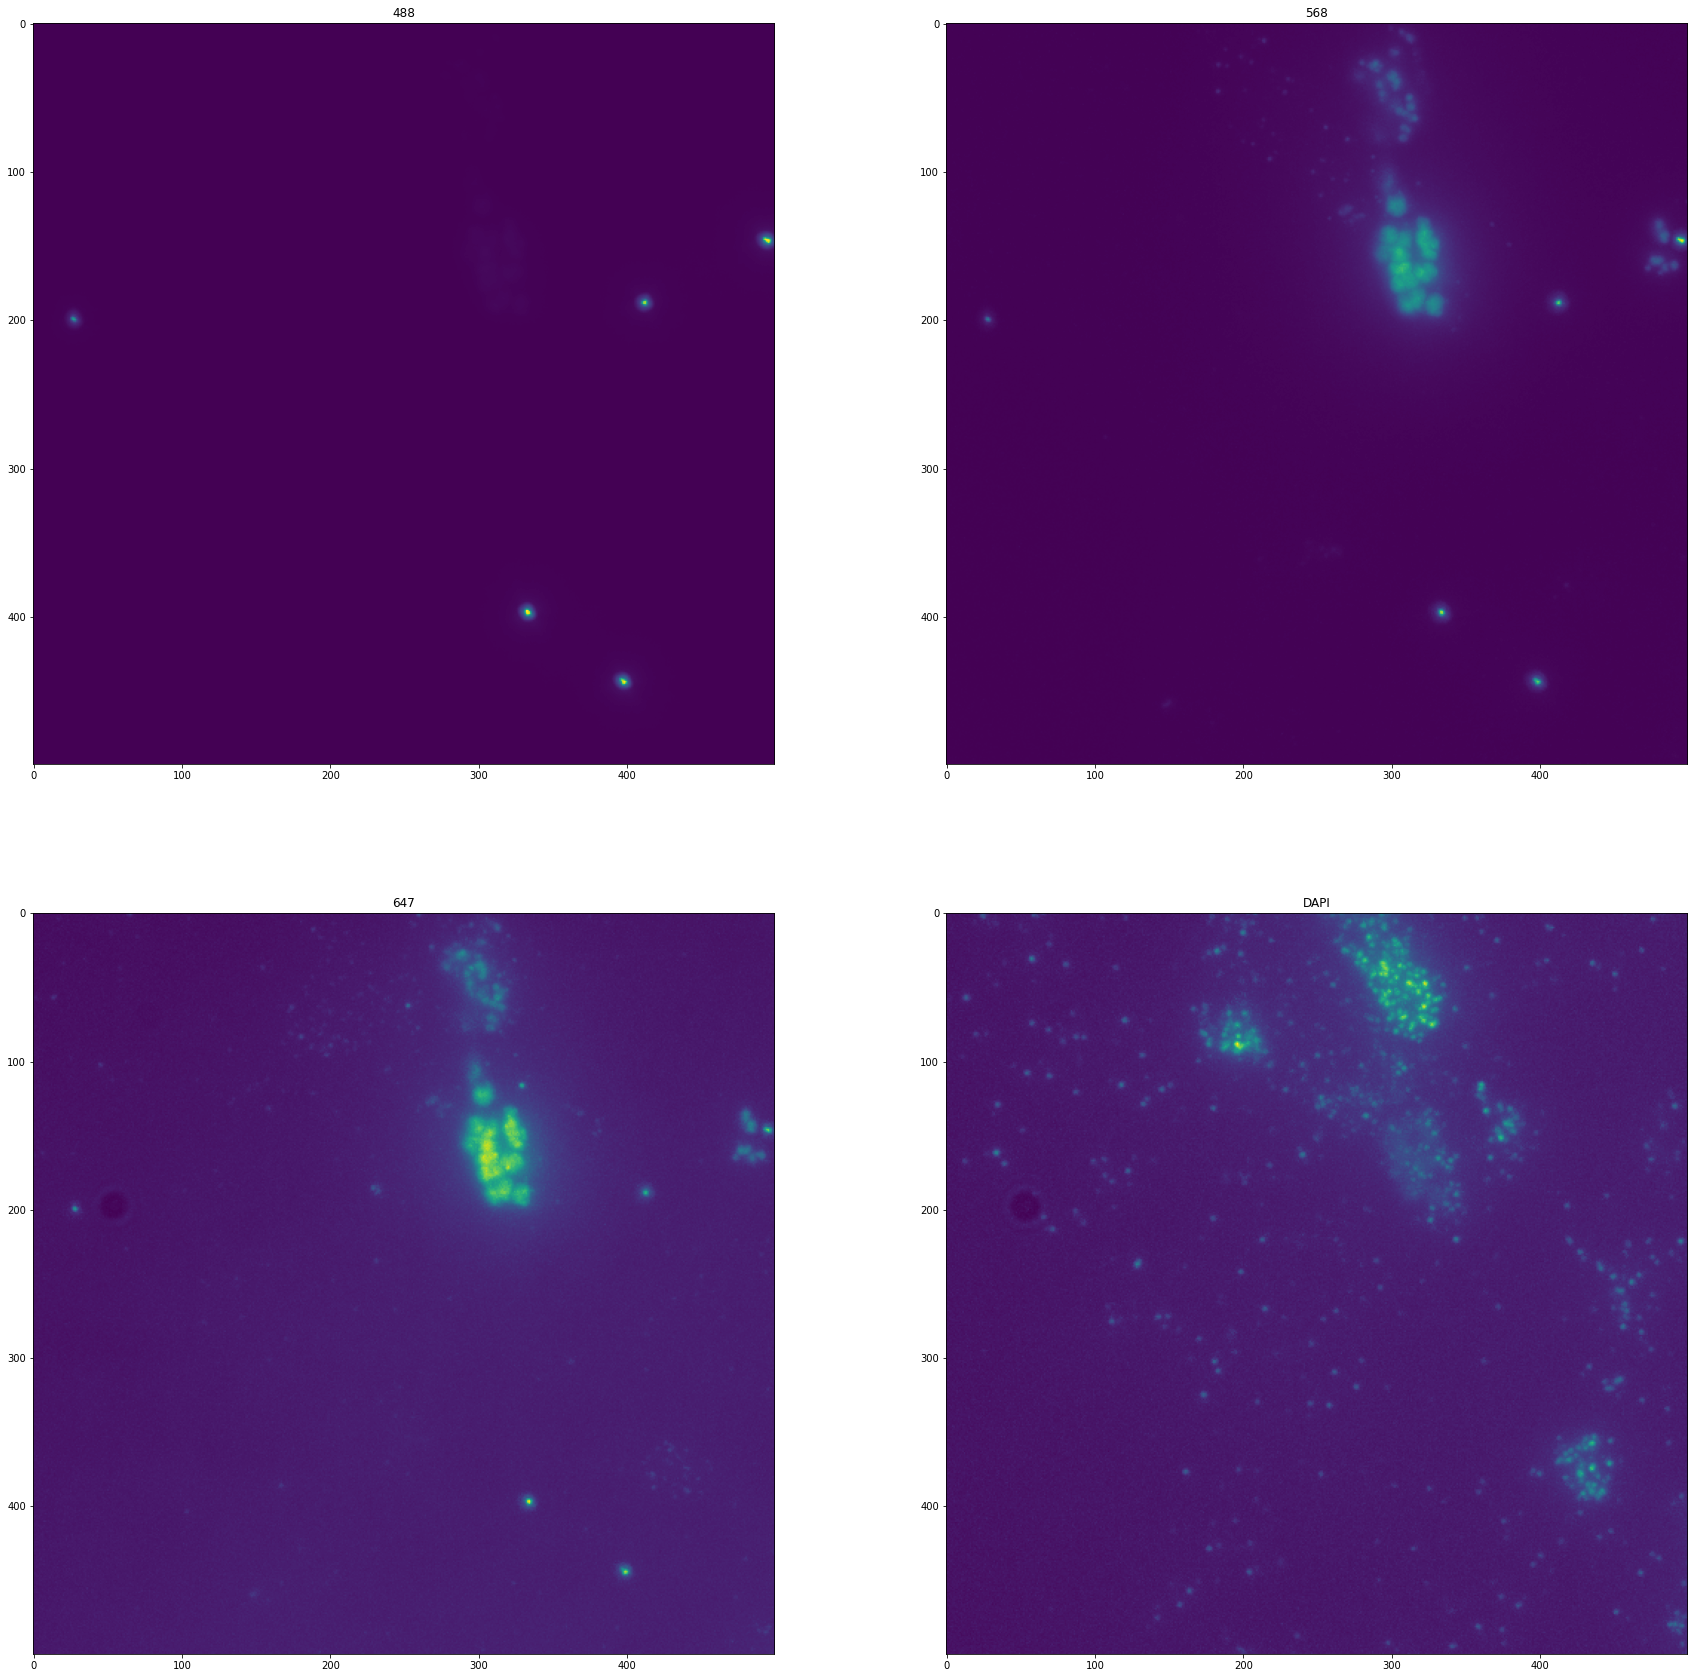

In [3]:
#viewing the image by channels

plt.figure(figsize=(30,30))

plt.subplot(2,2,1)
plt.imshow(img_sub[:,:,0])
plt.title("488")

plt.subplot(2,2,2)
plt.imshow(img_sub[:,:,1])
plt.title("568")

plt.subplot(2,2,3)
plt.imshow(img_sub[:,:,2])
plt.title("647")

plt.subplot(2,2,4)
plt.imshow(img_sub[:,:,3])
plt.title("DAPI")


In [4]:
np.histogram(img_sub.flatten(), bins=20)

(array([999060,    493,    132,     89,     67,     44,     25,      7,
            12,     15,      3,     11,      8,      0,      6,      4,
             1,      6,      4,     13], dtype=int64),
 array([  129. ,  3399.3,  6669.6,  9939.9, 13210.2, 16480.5, 19750.8,
        23021.1, 26291.4, 29561.7, 32832. , 36102.3, 39372.6, 42642.9,
        45913.2, 49183.5, 52453.8, 55724.1, 58994.4, 62264.7, 65535. ]))

In [5]:
#flattening images for linear fit
#taking every other pixel for speed of calculations

subset488 = img_sub[::2, ::2, 0].flatten()
subset568 = img_sub[::2, ::2, 1].flatten()
subset647 = img_sub[::2, ::2, 2].flatten()
subsetDAPI = img_sub[::2, ::2, 3].flatten()

In [11]:
#histogram shows that there are pixels well beyond the 4000 range
#these signals are most likely due to beads, so they must be separated
#to prevent skewing of calculations

beads = 4000

t_sub0 = subset488[subset568 < beads]
t_sub1 = subset568[subset568 < beads]
t_sub2 = subset647[subset568 < beads]

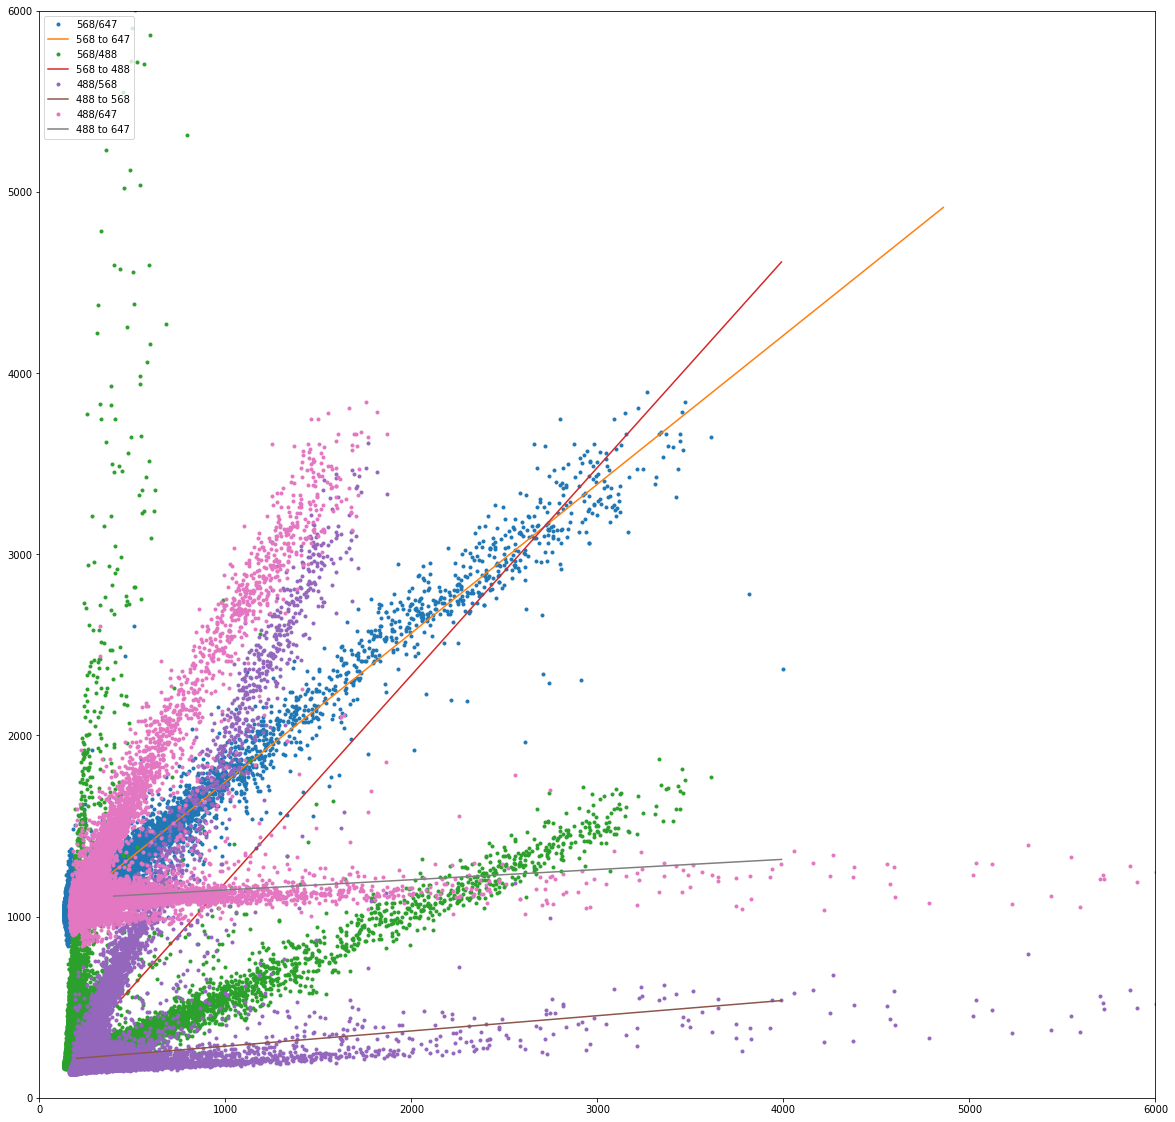

[8.21345505e-01 9.22003062e+02]
[ 1.14596248 40.27456128]
[8.41773908e-02 2.00670526e+02]
[5.63691726e-02 1.09064210e+03]


In [12]:
# first, perform least squares fit to attain coefficients of a polynomial function
# create an n-th degree, 1D polynomial to express the fit of data
# enter range of datapoints into function to generate line of best fit
# then plot against datapoints to see if there is mixing involved
# to isolate pixels with lipofuscin signal;

plt.figure(figsize=(20,20))

_568to647 = np.polyfit(t_sub1.astype(float),  t_sub2.astype(float), 1)
plt.plot(t_sub1, t_sub2, '.', label='568/647')
fx_568to647 = np.poly1d(_568to647)
a = np.arange(200,np.max(subset568),10);
plt.plot(a, fx_568to647(a), label='568 to 647')

_568to488 = np.polyfit(t_sub1.astype(float),  t_sub0.astype(float), 1)
plt.plot(t_sub1, t_sub0, '.', label='568/488')
fx_568to488 = np.poly1d(_568to488)
a = np.arange(200,np.max(t_sub1),10);
plt.plot(a, fx_568to488(a), label='568 to 488')

_488to568 = np.polyfit(t_sub0.astype(float), t_sub1.astype(float), 1)
plt.plot(t_sub0, t_sub1,'.', label='488/568')
fx_488to568 = np.poly1d(_488to568)
a = np.arange(200,np.max(t_sub1),10);
plt.plot(a, fx_488to568(a), label='488 to 568')

_488to647 = np.polyfit(t_sub0.astype(float),  t_sub2.astype(float), 1)
plt.plot(t_sub0,t_sub2, '.', label='488/647')
fx_488to647 = np.poly1d(_488to647)
a = np.arange(400,np.max(t_sub1),10);
plt.plot(a, fx_488to647(a), label='488 to 647')


plt.legend(loc='upper left')
plt.ylim(top=6000, bottom=0)
plt.xlim(left=0, right=6000)
plt.show()
print(_568to647)
print(_568to488)
print(_488to568)
print(_488to647)

In [ ]:
#bead signals per channel
b0 = subset488[subset488 > beads]
b1 = subset568[subset488 > beads]
b2 = subset647[subset488 > beads]

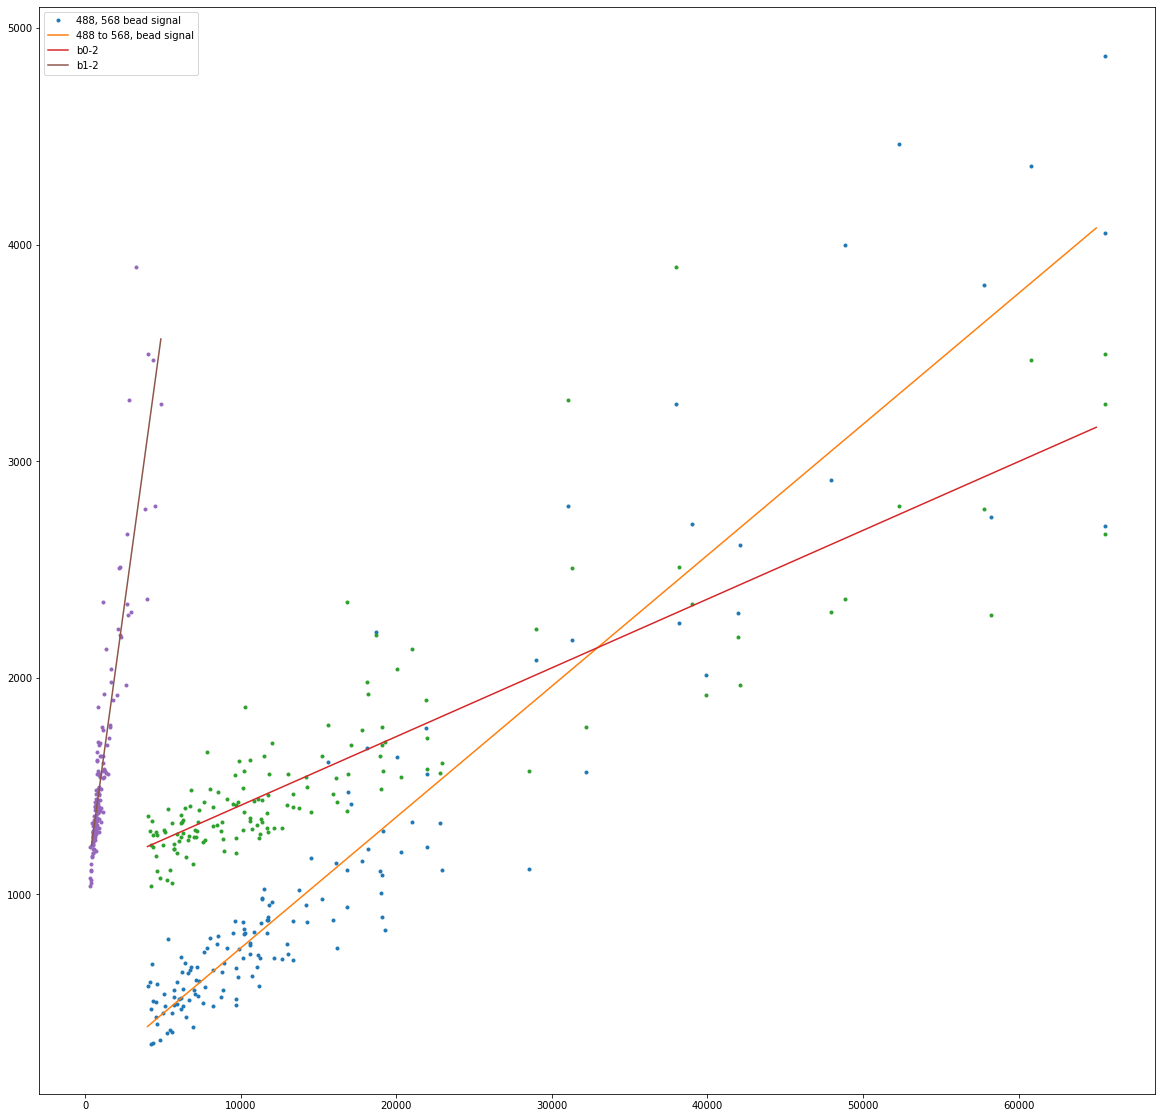

[6.04247606e-02 1.48839712e+02]
[3.1723471e-02 1.0943154e+03]
[5.23953183e-01 1.01731059e+03]


In [14]:
#same approach, but for signals in the range of bead intensity

plt.figure(figsize=(20,20))

beads_488to568 = np.polyfit(b0.astype(float),  b1.astype(float), 1)
plt.plot(b0, b1, '.', label='488, 568 bead signal')
fx_beads_488to568 = np.poly1d(beads_488to568)
a = np.arange(4000, np.max(b0), 1000);
plt.plot(a, fx_beads_488to568(a), label='488 to 568, bead signal')

beads_488to647 = np.polyfit(b0.astype(float),  b2.astype(float), 1)
plt.plot(b0, b2, '.')
fx_beads_488to647 = np.poly1d(beads_488to647)
a = np.arange(4000,np.max(b0),1000);
plt.plot(a, fx_beads_488to647(a), label='b0-2')

coeffsb12 = np.polyfit(b1.astype(float), b2.astype(float), 1)
plt.plot(b1, b2,'.')
polyLineb12 = np.poly1d(coeffsb12)
a = np.arange(400,np.max(b1),10);
plt.plot(a, polyLineb12(a), label='b1-2')

plt.legend(loc='upper left')
plt.show()
print(beads_488to568)
print(coeffsb02)
print(coeffsb12)

In [30]:
# based on these linear fits 
# we estimate some values for the mixing matrix


c0 = [1, coeffs12[1], coeffs02[0], 0, 0] #  lipofuscin

# for single-band emission filters, there is essentially zero crosstalk.
c1 = [ 1., 0., 0., 0., 0.] # Alexa 488  
c2 = [ 0., 1., 0., 0., 0.] # Alexa 568
c3 = [ 0., 0., 1., 0., 0.] # Alexa 647
c4 = [ 0., 0., 0., 1., 0.] # Alexa 750
c5 = [ 0., 0., 0., 0., 1.] # bead signal

# and once we normalize the channel weights for each label, we have our dictionary

c0 = c0/np.sqrt(np.dot(c0,c0))
c1 = c1/np.sqrt(np.dot(c1,c1))
c2 = c2/np.sqrt(np.dot(c2,c2))
c3 = c3/np.sqrt(np.dot(c3,c3))
c4 = c4/np.sqrt(np.dot(c4,c4))
c5 = c5/np.sqrt(np.dot(c5,c5))
testDict =np.array([
c0,
c1,
c2,
c3,
c4,
c5])
print(testDict)
print(testDict.shape)

[[1.08459446e-03 9.99999410e-01 6.11376921e-05 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00]]
(6, 5)


In [56]:
inputImage[0].shape

(500, 4)

In [47]:
alphaList =[0.001]
inputArray = img_sub.reshape(img_sub.shape[0], -1)
print(inputArray.shape)

for ii, alpha in enumerate(alphaList): 
    
    print(alpha)
    print(time.ctime())
    
    mySparseCoder= skd.SparseCoder(testDict, transform_algorithm='lasso_lars', transform_alpha = alpha, n_jobs = 16)
    
    # the fit_transform method for this class doesn't do any fitting because
    # the transform is based on the fixed input dictionary
    transformedData = mySparseCoder.fit_transform(inputArray)
    tData = transformedData.reshape(inputImage.shape[0], inputImage.shape[1], testDict.shape[0])
    tData = tData-tData.min()
    
    print(time.ctime())
    print(tData.shape)
    
    plt.figure(figsize=(30,30))
    
    for i in np.arange(0,6):
        
        plt.subplot(2, 3, i+1)
        plt.imshow(tData[:, :, i])
    
    plt.show()
    

    #  this off the shelf seems to work reasonably well for all these alpha values, but it is prohibitively slow for our application 
    # (3 min to do 3 colors and 3.2M pixels) is not fast enough when we routinely collect data with ~4 OoM more pixels.
    # I'm sure this method can be optimized for speed, but I also suspect there are better ways to do this!

0.001
Mon Mar 15 15:55:09 2021


ValueError: X has 4 features, but SparseCoder is expecting 5 features as input.

In [ ]:
# abortive attempt at using nonnegative matrix factorization. 
# I can't get anything useful out of this yet, having tested random and custom initialization. The unmixed data isnt.
# in principle, the initial testDict should not need to be recomputed, so time here fitting and transforming could be reduced to just the transform part

alphaList =[0.001, 0.01, .1]
l1_ratioList = [0., .5 , 1.]
n_components = 4
inputArray = inputImage.reshape(inputImage.shape[0]*inputImage.shape[1]*inputImage.shape[2],inputImage.shape[3])
print(inputArray.shape)
ii =0
for alpha in alphaList: 
    for l1_ratio in l1_ratioList:
        print alpha
        print l1_ratio
        starttime = time.clock()
        model = skd.NMF(n_components=n_components, init='custom', random_state=0, alpha = alpha, l1_ratio = 1.)
    #model.fit(inputArray) 
        print(inputArray[:,0].shape)
        transformedData = model.fit_transform(inputArray,W=np.hstack((inputArray[:,0:3],inputArray[:,2::])), H = testDict+.0001)
        tData = transformedData.reshape(inputImage.shape[0], inputImage.shape[1],inputImage.shape[2], n_components)
        tData = tData-tData.min()
        print(str(time.clock()-starttime))
        print(tData.shape)
        saveString ='//169.254.8.100/public/testData/HCT3-colorTESTNMF'+str(ii)+".tif"
        ii+=1
        tf.imsave(saveString, np.transpose(tData.astype(np.uint16), axes=[2,3,0,1]))
        plt.figure()
        for i in np.arange(0,4):
            plt.subplot(4,1,i+1)
            plt.imshow(np.max(tData[:,:,:,i], axis = 2))
        plt.show()
    

